# Propuesta de Proyecto: Recomendación de Videojuegos en Amazon
**IIC3633 Sistemas Recomendadores (2025-1)**  
Integrantes: **Geraldine Coli Acevedo**, **Carlos Olguín**, **René Saavedra Vargas**.  

## 1. Introducción

El siguiente cuaderno presenta una propuesta de proyecto para el curso IIC3633 Sistemas Recomendadores. Se realiza un análisis exploratorio de datos sobre un conjunto de datos de ratings de Amazon (enfocado en Videojuegos). El conjunto de datos se obtiene a partir de [Amazon Review Data (2018)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) de Jianmo Ni. En particular se utiliza el conjunto **"Small" subsets for experimentation: Video Games (Ratings only)** para obtener los ratings de los videojuegos, este archivo se puede descargar [aquí](https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Video_Games.csv). Y se utiliza Per-category data: Video Games (metadata) para obtener información adicional sobre los videojuegos (Nombre e ID), este archivo se puede descargar [aquí](https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/metaFiles2/meta_Video_Games.json.gz).

Cabe destacar que para utilizar el archivo de metadatos (meta_Video_Games.json.gz) se debe descomprimir el archivo y luego ejecutar el archivo **preprocessFiles.py**

## 2. Pasos preliminares

### 2.1. Variables

In [ ]:
TEST_SIZE = 0.2 
DATASET_SIZE = 0.05
RANDOM_STATE = 42

### 2.2. Instalación de dependencias


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable


### 2.3. Cargar datos

In [ ]:
ratings_df = pd.read_csv('videogame_ratings.csv')   # userId, itemId, rating, timestamp
videogames_df = pd.read_csv('videogames.csv')       # itemId, name

ratings_df.head()

,itemId,userId,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [ ]:
# shape ratings df and videogames df, unique userId

print(f"ratings_df shape: {ratings_df.shape}")
print(f"videogames_df shape: {videogames_df.shape}")
print(f"N° Usuarios: {ratings_df['userId'].nunique()}")
print(f"N° Videogames: {ratings_df['itemId'].nunique()}")

ratings_df shape: (2565349, 4)
videogames_df shape: (84819, 2)
N° Usuarios: 1540618
N° Videogames: 71982


### 2.4. Preprocesar datos

In [ ]:
print(videogames_df['name'].duplicated().sum())  

16154


Existen videojuegos que poseen más de 1 ID en Amazon, esto es debido a versiones/metadata distinta dentro de los ítemes/reviews. Por lo tanto, realizamos un preprocesamiento donde dejamos un solo ID por videojuego. (El primer ID encontrado) y lo reemplazamos en el dataset de reviews. Esto se hace para evitar duplicados y que el modelo no aprenda de más de un ID por videojuego. 

In [ ]:
# 1. Mapeo de nombres a IDs reales y de Ids a reales
name_to_real_id = videogames_df.groupby('name')['itemId'].first()
videogames_df['realId'] = videogames_df['name'].map(name_to_real_id)
id_to_real = videogames_df.set_index('itemId')['realId'].to_dict()

# 2. Reemplazamos itemId en ratings_df
ratings_df['itemId'] = ratings_df['itemId'].map(id_to_real)
videogames_df['itemId'] = videogames_df['realId']

# 3. Limpiamos el DataFrame de videojuegos
clean_videogames_df = (
    videogames_df
    .drop(columns=['realId'])
    .drop_duplicates(subset='itemId')
    .reset_index(drop=True)
)

videogames_df = clean_videogames_df


In [ ]:
print(f"N° Videogames: {ratings_df['itemId'].nunique()}")

N° Videogames: 68662


### 2.5. Particionar datos

Algo a destacar del dataset es lo siguiente:


In [29]:
ratings_per_user = df.groupby("userId").size()
one_rating = round(ratings_per_user[ratings_per_user == 1].count()/len(ratings_per_user) * 100, 2) 
print(f"Porcentaje de usuarios con una sola interacción: {one_rating}%")

Porcentaje de usuarios con una sola interacción: 94.18%


Más del 90% de los usuarios han realizado una solo review. Esto indica que tenemos un problema de _sparsity_ y _cold-start_ en el dataset. Dado esto, no podemos particionar los datos mantiendo usuarios en train y test, pero podemos asegurarnos que los videojuegos estén en ambos datasets. Por lo tanto, la partición se realiza de la siguiente manera:

In [31]:
df = ratings_df.sample(frac=DATASET_SIZE, random_state=RANDOM_STATE)

# 1. Split inicial utilizando TEST_SIZE
train_df, val_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 2. Detectar cold-start en validación (no queremos ítemes que no estén en train)
train_items = set(train_df['itemId'])
cold_mask = ~val_df['itemId'].isin(train_items)

# 3. Separar interacciones frías
cold_df = val_df[cold_mask]
val_df = val_df[~cold_mask]

# 4. Reintegrar las frías al entrenamiento
train_df = pd.concat([train_df, cold_df], ignore_index=True)

# 5. Ajustar test al valor TEST_SIZE exacto: (Los pasos anteriores reducen el tamaño de val_df)
desired_n_val = int(TEST_SIZE * len(df))
current_n_val = len(val_df)
n_needed = desired_n_val - current_n_val

if n_needed > 0:
    # Tomamos n_needed ejemplos adicionales desde train_df
    extra_val = train_df.sample(n=n_needed, random_state=RANDOM_STATE)
    
    # Los quitamos de train y los añadimos a val
    train_df = train_df.drop(extra_val.index).reset_index(drop=True)
    val_df = pd.concat([val_df, extra_val], ignore_index=True)

# 6. Comprobación de tamaños
print(f"Train: {train_df.shape[0]} filas")
print(f"Validation: {val_df.shape[0]} filas")
print(f"Real test size: {val_df.shape[0] / (train_df.shape[0] + val_df.shape[0]):.2%}")

Train: 102614 filas
Validation: 25653 filas
Real test size: 20.00%


### 2.6. Estadísticas de los datos

In [32]:
def df_stats(df):
    n_users = df['userId'].nunique()
    n_items = df['itemId'].nunique()
    total_ratings = len(df)
    avg_rpu = round(total_ratings / n_users, 1)
    avg_rpi = round(total_ratings / n_items, 1)
    avg_rating = round(df['rating'].mean(), 1)
    std_rating = round(df['rating'].std(), 1)
    max_by_user = df.groupby('userId').size().max()
    max_by_item = df.groupby('itemId').size().max()
    return {
        'Número de usuarios': n_users,
        'Número de ítems': n_items,
        'Cantidad total de ratings': total_ratings,
        'Promedio de ratings por usuario': avg_rpu,
        'Promedio de ratings por ítem': avg_rpi,
        'Rating promedio': avg_rating,
        'Desviación estándar del rating': std_rating,
        'Máximo de ratings por usuario': max_by_user,
        'Máximo de ratings por ítem': max_by_item,
    }


In [33]:
stats_train = df_stats(train_df)
stats_val   = df_stats(val_df)

table = PrettyTable()
table.title = "Tabla estatísticas de entrenamiento y validación"
table.field_names = ["Métrica", "Entrenamiento", "Validación"]
for metric in stats_train.keys():
    table.add_row([metric, stats_train[metric], stats_val[metric]])
print(table)


+--------------------------------------------------------------+
|       Tabla estatísticas de entrenamiento y validación       |
+---------------------------------+---------------+------------+
|             Métrica             | Entrenamiento | Validación |
+---------------------------------+---------------+------------+
|        Número de usuarios       |     96137     |   25158    |
|         Número de ítems         |     25331     |    9271    |
|    Cantidad total de ratings    |     102614    |   25653    |
| Promedio de ratings por usuario |      1.1      |    1.0     |
|   Promedio de ratings por ítem  |      4.1      |    2.8     |
|         Rating promedio         |      4.0      |    4.0     |
|  Desviación estándar del rating |      1.4      |    1.4     |
|  Máximo de ratings por usuario  |       35      |     9      |
|    Máximo de ratings por ítem   |      324      |     98     |
+---------------------------------+---------------+------------+


Realizamos gráficos para analizar los datos.

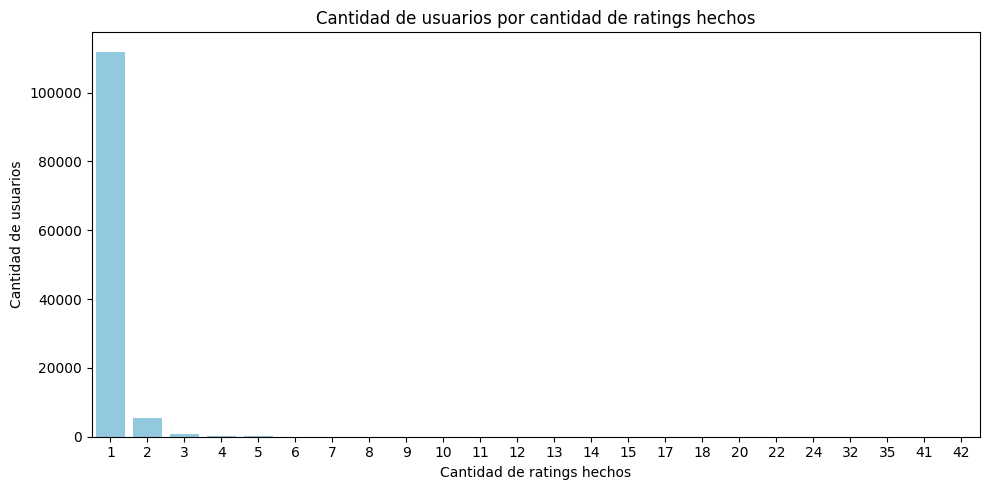

In [34]:
ratings_per_user = df.groupby("userId").size()
count_by_rating_count = ratings_per_user.value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=count_by_rating_count.index, y=count_by_rating_count.values, color='skyblue')
plt.title("Cantidad de usuarios por cantidad de ratings hechos")
plt.xlabel("Cantidad de ratings hechos")
plt.ylabel("Cantidad de usuarios")
plt.tight_layout()
plt.show()


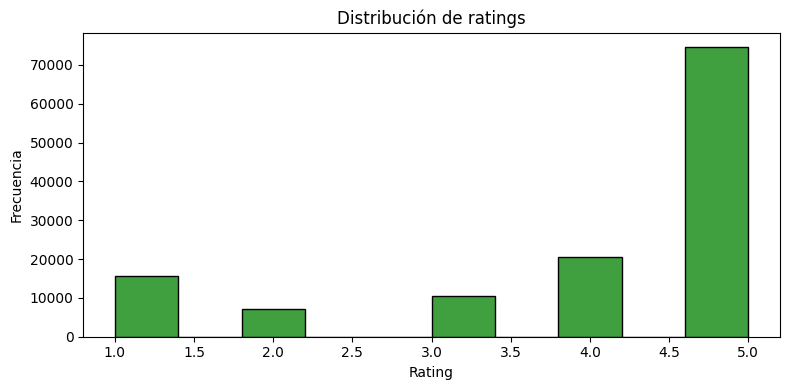

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df["rating"], bins=10, color='green')
plt.title("Distribución de ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## 3. Modelos de prueba

Realizamos pruebas con diferentes modelos simples de referencia. Utilizamos una clase RecomendadorBase que se utiliza para crear los otros recomendadores.

In [ ]:
class RecomendadorBase:
    """
    Clase base para todos los recomendadores.
    Formato a utilizar: userId, itemId, rating
    """
    def fit(self, ratings: pd.DataFrame):
        raise NotImplementedError

    def recommend(self, user_id, n_items=10):
        raise NotImplementedError

class RecomendadorRandom(RecomendadorBase):
    """
    Recomendador aleatorio.
    """
    def fit(self, ratings: pd.DataFrame):
        self.items = ratings['itemId'].unique()

    def recommend(self, user_id, n_items=10):
        return np.random.choice(self.items, size=n_items, replace=False).tolist()

class RecomendadorPopular(RecomendadorBase):
    """
    Recomendador basado en popularidad.
    """
    def fit(self, ratings: pd.DataFrame):
        counts = ratings['itemId'].value_counts()
        self.popular_items = counts.index.tolist()

    def recommend(self, user_id, n_items=10):
        return self.popular_items[:n_items]

class RecomendadorRatingPromedio(RecomendadorBase):
    """
    Recomendador basado en rating promedio.
    """
    def fit(self, ratings: pd.DataFrame):
        means = ratings.groupby('itemId')['rating'].mean()
        self.top_rated_items = means.sort_values(ascending=False).index.tolist()

    def recommend(self, user_id, n_items=10):
        return self.top_rated_items[:n_items]


In [ ]:
recommender_random = RecomendadorRandom()
recommender_random.fit(train_df)

recommender_popular = RecomendadorPopular()
recommender_popular.fit(train_df)

recommender_rating_promedio = RecomendadorRatingPromedio()
recommender_rating_promedio.fit(train_df)

In [35]:
id_to_name = videogames_df.set_index('itemId')['name'].to_dict()
def get_recommendations(recommender, user_id, n_items=10):
    item_ids = recommender.recommend(user_id, n_items)
    return [id_to_name[item_id] for item_id in item_ids]

In [39]:
# Ejemplo de recomendaciones para un usuario aleatorio
user_id = train_df['userId'].sample(1).values[0]

print(f"Recomendaciones para el usuario {user_id}:")
print("Recomendador aleatorio:", get_recommendations(recommender_random, user_id))
print("Recomendador popular:", get_recommendations(recommender_popular, user_id))
print("Recomendador rating promedio:", get_recommendations(recommender_rating_promedio, user_id))

Recomendaciones para el usuario A2MHMDU7UF831C:
Recomendador aleatorio: ['Killing Floor 2 [Online Game Code]', 'PS3 Controller Silicon Sleeve Protector - Black', 'Avatar: The Game', 'PSP All In One Case', 'Wii 15-in-1 Family Pack - White', 'Skylanders: Portal of Power For Nintendo 3DS - New In Bulk Packaging', ' Puzzle Quest [Download]', 'Guitar Hero Smash Hits - Xbox 360', 'SADES A60 7.1 USB Surround Sound Stereo Over-the-Ear Gaming Headset with Mic Bass, Vibration, Noise-Canceling, Volume Control for PC (White)', 'Grand Theft Auto V - PlayStation 3']
Recomendador popular: ['Diablo III', 'Redragon M601 Wired Gaming Mouse, Ergonomic, Programmable 6 Buttons, 3200 DPI with Red LED Mouse for Windows PC Games - Black', 'HAVIT HV-MS672 3200DPI Wired Mouse, 4 Adjustable DPI Levels, 800/1200/2400/3200DPI, 7 Circular &amp; Breathing LED Light, 6 Buttons (Black)(Updated Version)', 'Playstation Plus: 3 Month Membership [Digital Code]', 'StarCraft II: Wings of Liberty', 'HyperX Cloud Gaming Heads

Utilizamos **Hit Rate** como métrica de evaluación. Una métrica simple que nos dice si el modelo es capaz de predecir un videojuego que le gusta al usuario.

In [40]:
def hit_rate(recommender, val_df, n_items=10):
    hits = 0
    total = 0

    for user_id in val_df['userId'].unique():
        true_items = set(val_df[val_df['userId'] == user_id]['itemId'])

        try:
            recommended_items = recommender.recommend(user_id, n_items=n_items)
        except: # Evitamos errores si el usuario no tiene ratings
            continue

        hits += any(item in true_items for item in recommended_items)
        total += 1

    return hits / total if total > 0 else 0.0

In [41]:
print("Random Hit-Rate:", hit_rate(recommender_random, val_df))
print("Popular Hit-Rate:", hit_rate(recommender_popular, val_df))
print("Rating promedio Hit-Rate:", hit_rate(recommender_rating_promedio, val_df))

Random Hit-Rate: 0.0004769854519437157
Popular Hit-Rate: 0.020430876858255825
Rating promedio Hit-Rate: 0.0
